In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import numpy as np 
import pathlib

# Importing utitility functions for training
from PT_files.model import DnCNN, DnCNN_B
from PT_files.Dataset import Img_Dataset, Large_Img_Dataset
import PT_files.preprocess_data as ppd
import PT_files.save_load as sl
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

Using cuda device


# THIS MUST BE REDONE DUE TO THE HARDCODED VALUES USED AS THE STARTS & ENDS OF THE HORIZONTAL & VERTICAL INDICES. MEANING: LOOK AT THE `h_start/h_end/w_start/w_end` FOR THE VERT/HORIZ PASS FUNCTIONS! THERE ARE HARDCODED TUPLES WITHIN THEM. PROBABLY NEED TO GENERALIZE EVERYTHING TOO

# BUT IT'S PROMISING BC AT LEAST THIS VERSION DOESN'T TIME OUT

In [2]:
data_6k = sl.NERSC_load('test_data70-6000.npy')

In [3]:
def grid_window(dataset,
                model,
                model_params,
                samp_idx,
                h_start,
                h_end,
                w_start,
                w_end):
    
    """
    Function to calculate a specified sized inference window.
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Pytorch model
        DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    h_start: int
        The height starting index of the inference window.
        E.g. It would be the origin for the y-coord in a 2-D plot
    h_end: int
        The height ending index of the inference window.
        E.g. It would be the end of the y-axis for the y-coord 
        in a 2-D plot
    w_start: int
        The horizontal starting index of the inference window.
        E.g. It would be the origin for the x-coord in a 2-D plot
    w_end: int
        The horizontal ending index of the inference window.
        E.g. It would be the end of the x-axis for the x-coord 
        in a 2-D plot
   
        
    Returns:
    --------
    full: np.array
        Array of the models output over the window region.
    count: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    
    full = np.empty((1, 1, 6000, 6000))
    count = np.empty((1, 1, 6000, 6000))
    
    noise_data = dataset[0]
    params_name = model_params
    
    current_dir = pathlib.Path().resolve()
    model_params_path = current_dir / 'Model_params'
    assert model_params_path.exists()
    model_path = model_params_path / params_name
    print('Check pt 1')
    
    model = model()
    model.to(device)
    model.load_state_dict(torch.load(str(model_path)))
    model.eval()
    print('Check pt 2')

    
    with torch.no_grad():
        
        torch.cuda.empty_cache()
        test_noise = torch.as_tensor(noise_data[samp_idx:samp_idx+1, :, h_start:h_end, w_start:w_end])
        test_noise = test_noise.to(device)
        print('Check pt 3')

        
        output = model(test_noise)
        resid_img = output.cpu().detach().numpy()
        print('Check pt 4')

        
        full[:, :, h_start:h_end, w_start:w_end] += resid_img
        count[:, :, h_start:h_end, w_start:w_end] += 1
        print('Run finished')
        
    return full, count

In [5]:
for i in range(9):

    full, count = grid_window(dataset=data_6k,
                          model=DnCNN,
                          model_params="2k_model_bs64_e200.pth",
                          samp_idx=0,
                          h_start=2000+i,
                          h_end=4000,
                          w_start=0,
                          w_end=2000)

fig, ax = plt.subplots(1, 1, figsize=(40,36))
vmin, vmax = np.percentile(data_6k[0][0][0], (1,99))

ax.imshow(full[0][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax.axis('off')
ax.set_title('Denoised Sample (2k Model)', fontsize=30)

In [6]:
# device = "cpu"

In [7]:
def horizontal_inf_pass(dataset,
                        model,
                        model_params,
                        samp_idx,
                        window_size,
                        window_move_dist):
    """
    Horizontal inference pass. Ie. this doesn't cover the upper & lower
    most 1000 pixels (ie. should have a 1000 pixel high empty row
    on top and bottom)
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Pytorch model
        DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    window_size: int
        Width/height of the inference window that moves over the full 
        6k by 6k image
    window_move_dist: int
        The distance the inference window moves between each calculation.
        E.g. if window_move_dist=1000 the distance between one inference
        calculation and the next will be 1000
        
    Returns:
    --------
    full_h: np.array
        Array of the models output over the specified window regions.
    count_h: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    
    inf_patch_size = window_size
    inf_patch_length = int(len(dataset[0][0][0]) / inf_patch_size)
    window_move_distance = window_move_dist
    
    window_end_idx = []
    for i in range(inf_patch_length):
        window_end_idx.append(inf_patch_size*(i+1))
        
    direction_dep_window = list(np.array(window_end_idx) - window_move_distance)
    # vert_pass_end_idxs = [(1000, 3000), (3000, 5000)]
    # full_pass_end_idxs = [(0, 2000), (2000, 4000), (4000, 6000)] 
    vert_pass_end_idxs = [(direction_dep_window[0], direction_dep_window[1]),
                          (direction_dep_window[1], direction_dep_window[2])]
    
                        
        
        # Horizontal pass
    for i in range(len(window_end_idx)):
        for j in range(len(vert_pass_end_idxs)):
            full_h_L, count_h_L = grid_window(dataset=dataset,
                                      model=model,
                                      model_params=model_params,
                                      samp_idx=samp_idx,
                                      h_start=vert_pass_end_idxs[0][0],
                                      h_end=vert_pass_end_idxs[0][1],
                                      w_start=0,
                                      w_end=window_end_idx[i])
            print('Pass')

            full_h_R, count_h_R = grid_window(dataset=dataset,
                                      model=model,
                                      model_params=model_params,
                                      samp_idx=0,
                                      h_start=vert_pass_end_idxs[1][0],
                                      h_end=vert_pass_end_idxs[1][1],
                                      w_start=0,
                                      w_end=window_end_idx[i])
            print('Pass')
            
    full_h = full_h_L + full_h_R
    count_h = count_h_L + count_h_R
    
    return full_h, count_h

Gonna need to fix this! It has 12 runs when I thought it would only have 12. So somethings amiss here

In [8]:
full_h, count_h = horizontal_inf_pass(dataset=data_6k,
                        model=DnCNN,
                        model_params="2k_model_bs64_e200.pth",
                        samp_idx=0,
                        window_size=2000,
                        window_move_dist=1000)

Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass


In [9]:
# fig, ax = plt.subplots(1, 1, figsize=(40,36))
# vmin, vmax = np.percentile(data_6k[0][0][0], (1,99))

# ax.imshow(full_h[0][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
# ax.axis('off')
# ax.set_title('Denoised Sample (2k Model)', fontsize=30)    

In [10]:
def vertical_inf_pass(dataset,
                        model,
                        model_params,
                        samp_idx,
                        window_size,
                        window_move_dist):
    """
    Vertical inference pass. Ie. this doesn't cover the left & right
    most 1000 pixels (ie. should have a 1000 pixel wide empty column
    on left and right)
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Pytorch model
        DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    window_size: int
        Width/height of the inference window that moves over the full 
        6k by 6k image
    window_move_dist: int
        The distance the inference window moves between each calculation.
        E.g. if window_move_dist=1000 the distance between one inference
        calculation and the next will be 1000
        
    Returns:
    --------
    full_v: np.array
        Array of the models output over the specified window regions.
    count_v: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    inf_patch_size = window_size
    inf_patch_length = int(len(dataset[0][0][0]) / inf_patch_size)
    window_move_distance = window_move_dist
    
    window_end_idx = []
    for i in range(inf_patch_length):
        window_end_idx.append(inf_patch_size*(i+1))
        
    direction_dep_window = list(np.array(window_end_idx) - window_move_distance)
    # vert_pass_end_idxs = [(1000, 3000), (3000, 5000)]
    # full_pass_end_idxs = [(0, 2000), (2000, 4000), (4000, 6000)] 
    vert_pass_end_idxs = [(direction_dep_window[0], direction_dep_window[1]),
                          (direction_dep_window[1], direction_dep_window[2])]
    
                        
        
        # Vertical pass
    for i in range(len(window_end_idx)):
        for j in range(len(vert_pass_end_idxs)):
            full_v_L, count_v_L = grid_window(dataset=dataset,
                                      model=model,
                                      model_params=model_params,
                                      samp_idx=samp_idx,
                                      h_start=0,
                                      h_end=window_end_idx[i],
                                      w_start=vert_pass_end_idxs[0][0],
                                      w_end=vert_pass_end_idxs[0][1])
            print('Pass')

            full_v_R, count_v_R = grid_window(dataset=dataset,
                                      model=model,
                                      model_params=model_params,
                                      samp_idx=0,
                                      h_start=0,
                                      h_end=window_end_idx[i],
                                      w_start=vert_pass_end_idxs[1][0],
                                      w_end=vert_pass_end_idxs[1][1])
            print('Pass')
            
    full_v = full_v_L + full_v_R
    count_v = count_v_L + count_v_R
    
    return full_v, count_v

Same as the horizontal pass. Somethings wrong here in that there should only be 6 calls to the `grid_window` function, but there seems to be 12...

In [11]:
full_v, count_v = vertical_inf_pass(dataset=data_6k,
                        model=DnCNN,
                        model_params="2k_model_bs64_e200.pth",
                        samp_idx=0,
                        window_size=2000,
                        window_move_dist=1000)

Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Pass


In [12]:
# fig, ax = plt.subplots(1, 1, figsize=(40,36))
# vmin, vmax = np.percentile(data_6k[0][0][0], (1,99))

# ax.imshow(full_v[0][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
# ax.axis('off')
# ax.set_title('Denoised Sample (2k Model)', fontsize=30)

In [13]:
def full_img_pass(dataset,
                    model,
                    model_params,
                    samp_idx,
                    window_size):
    
    """
    Full inference pass. Ie. this goes over every single pixel
    within the entire 6k by 6k image
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Pytorch model
        DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    window_size: int
        Width/height of the inference window that moves over the full 
        6k by 6k image
        
    Returns:
    --------
    full: np.array
        Array of the models output over the specified window regions.
    count: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    
    inf_patch_size = window_size
    inf_patch_length = int(len(dataset[0][0][0]) / inf_patch_size)
    
    window_end_idx = []
    for i in range(inf_patch_length):
        window_end_idx.append(inf_patch_size*(i+1))
        
    # Full image pass
    for i in range(len(window_end_idx)):
        for j in range(len(window_end_idx)):
            full, count = grid_window(dataset=dataset,
                                  model=model,
                                  model_params=model_params,
                                  samp_idx=samp_idx,
                                  h_start=0,
                                  h_end=window_end_idx[i],
                                  w_start=0,
                                  w_end=window_end_idx[j])
            print('Pass')
            
    return full, count

Trying to make this more generalizable using a `for loop` to create multiple variables. My idea is to generalize this `full_img_pass` func to take the size of the model ie. 1k, 2k, ... 6k and breaks the 6k img into the desired window patchs. So for 2k model we'll have 9 total patches for a 6k img, but for a 1k model we'd have 36 patches.

Thus I want to `for loop` over these specific end points for the windows.

[0, 2000, 4000, 6000]
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished


Text(0.5, 1.0, 'Denoised Sample (2k Model)')

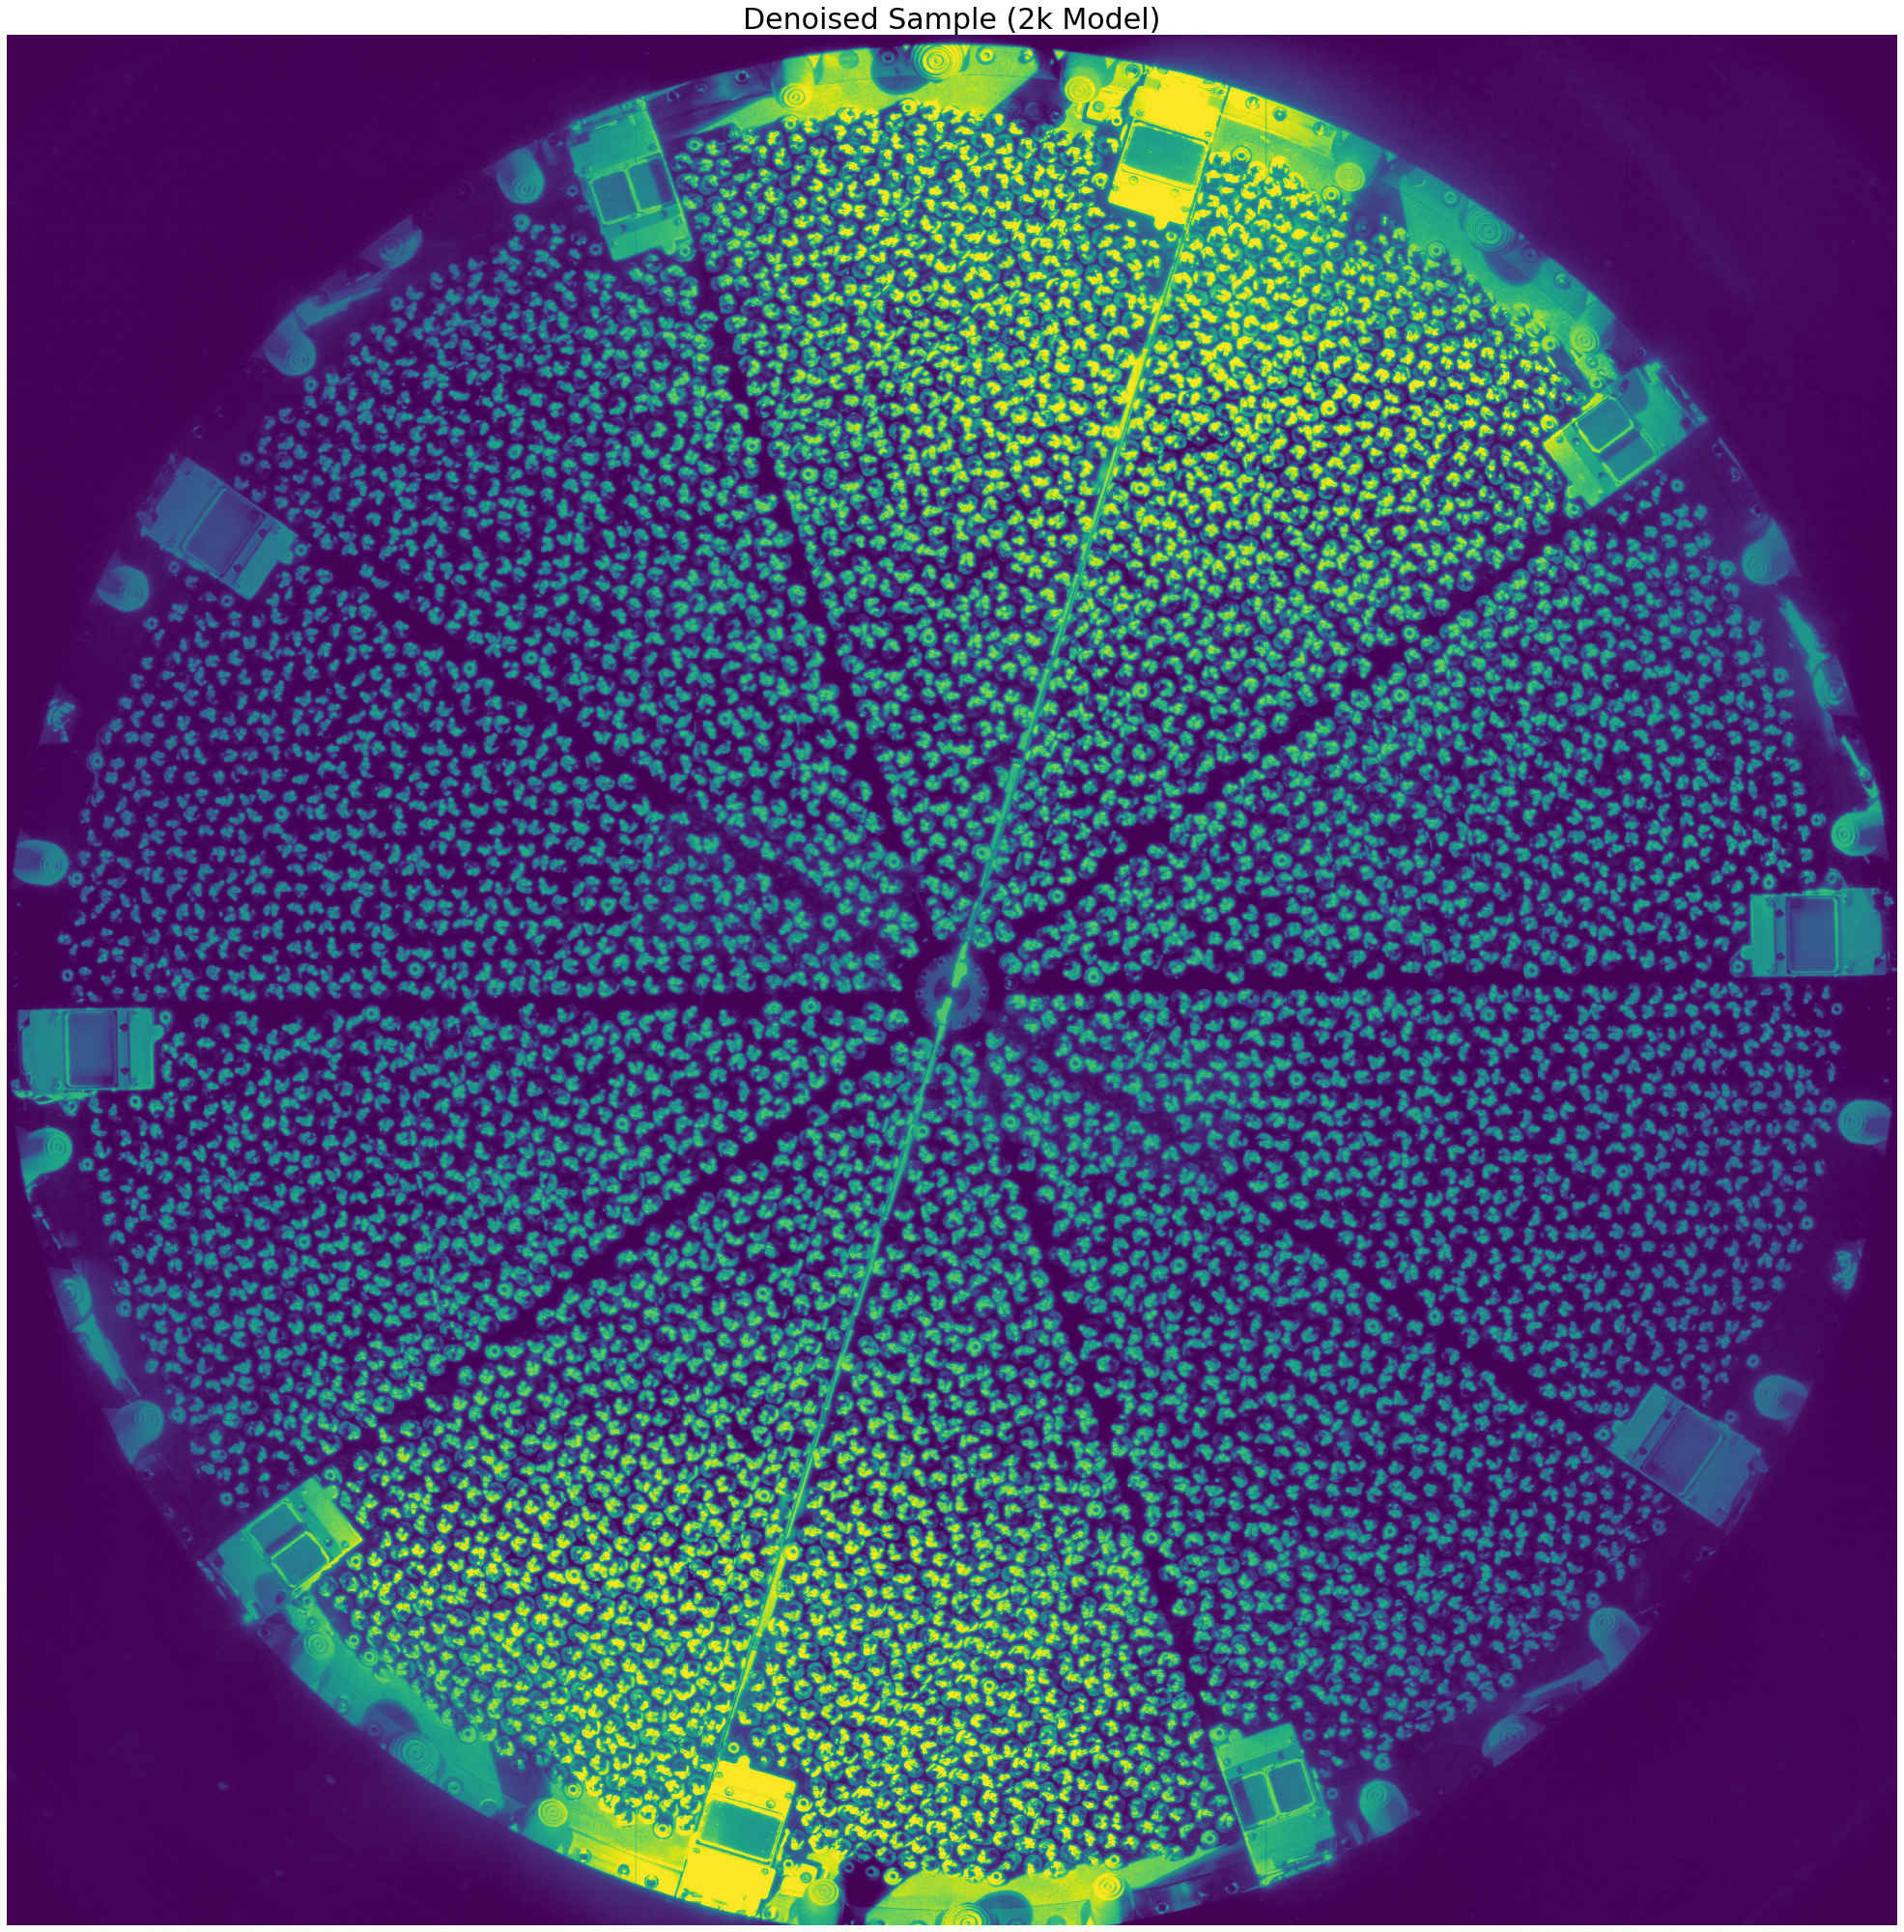

In [38]:
dataset=data_6k
model=DnCNN
model_params="2k_model_bs64_e200.pth"
samp_idx=0
window_size=2000


#Inference patch size == size of grid_window func
inf_patch_size = window_size 
#Inference patch length == how many windows fit in a row/col
inf_patch_length = int(len(dataset[0][0][0]) / inf_patch_size)

window_end_idx = []
for i in range(inf_patch_length):
    window_end_idx.append(inf_patch_size*(i)) # appends 0,2k,4k
window_end_idx.append(len(dataset[0][0][0])) # appends endpt ie. 6k

    
print(window_end_idx)

# Full image pass

# for i in range(3)
for i in range(len(window_end_idx)-1):

    full_c1, count_c1 = grid_window(dataset=dataset,
                                    model=model,
                                    model_params=model_params,
                                    samp_idx=samp_idx,
                                    h_start=window_end_idx[0],
                                    h_end=window_end_idx[i+1],
                                    w_start=0,
                                    w_end=window_end_idx[1])

    full_c2, count_c2 = grid_window(dataset=dataset,
                                    model=model,
                                    model_params=model_params,
                                    samp_idx=samp_idx,
                                    h_start=window_end_idx[0],
                                    h_end=window_end_idx[i+1],
                                    w_start=window_end_idx[1],
                                    w_end=window_end_idx[2])
    
    full_c3, count_c3 = grid_window(dataset=dataset,
                                    model=model,
                                    model_params=model_params,
                                    samp_idx=samp_idx,
                                    h_start=window_end_idx[0],
                                    h_end=window_end_idx[i+1],
                                    w_start=window_end_idx[2],
                                    w_end=window_end_idx[3])
  
    
full_c = full_c1 + full_c2 + full_c3
count_c = count_c1 + count_c2 + count_c3
    
    

fig, ax = plt.subplots(1, 1, figsize=(40,36))
vmin, vmax = np.percentile(data_6k[0][0][0], (1,99))

ax.imshow(full_c[0][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax.axis('off')
ax.set_title('Denoised Sample (2k Model)', fontsize=30)

In [19]:
full, count = full_img_pass(dataset=data_6k,
                        model=DnCNN,
                        model_params="2k_model_bs64_e200.pth",
                        samp_idx=0,
                        window_size=2000)

Check pt 1
Check pt 2
Check pt 3
Check pt 4
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Pass
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Pass
Check pt 1
Check pt 2
Check pt 3


RuntimeError: CUDA out of memory. Tried to allocate 77.25 GiB (GPU 0; 39.59 GiB total capacity; 26.03 GiB already allocated; 11.80 GiB free; 26.03 GiB reserved in total by PyTorch)

In [14]:
# fig, ax = plt.subplots(1, 1, figsize=(40,36))
# vmin, vmax = np.percentile(data_6k[0][0][0], (1,99))

# ax.imshow(full[0][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
# ax.axis('off')
# ax.set_title('Denoised Sample (2k Model)', fontsize=30)

In [16]:
def afterburner_func(dataset,
                     model,
                     model_params,
                     samp_idx,
                     window_size,
                     window_move_dist):
    
    """
    Computes every inference pass. Ie. the horizontal (empty top & 
    bottom of inference image), the vertical (empty right & left
    column of inference image), and the full (entire image covered)
    pass. Once every pass is completed calculates the average pixel
    value for every pixel.
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Pytorch model
        DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    window_size: int
        Width/height of the inference window that moves over the full 
        6k by 6k image
    window_move_dist: int
        The distance the inference window moves between each calculation.
        E.g. if window_move_dist=1000 the distance between one inference
        calculation and the next will be 1000
        
    Returns:
    --------
    full_avg: np.array
        Averaged array of the 3 different full pixel arrays from the 
        different passes.
    count_v: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    
   
    
    full_v, count_v = vertical_inf_pass(dataset=dataset,
                        model=model,
                        model_params=model_params,
                        samp_idx=samp_idx,
                        window_size=window_size,
                        window_move_dist=window_move_dist)
    print("Vertical pass completed")

    
    full_h, count_h = horizontal_inf_pass(dataset=dataset,
                        model=model,
                        model_params=model_params,
                        samp_idx=samp_idx,
                        window_size=window_size,
                        window_move_dist=window_move_dist)
    print("Horizontal pass completed")
    
    full, count = full_img_pass(dataset=dataset,
                        model=model,
                        model_params=model_params,
                        samp_idx=samp_idx,
                        window_size=window_size)
    print("Full img pass completed")

    
    tot_full = full + full_v + full_h
    tot_count = count + count_v + count_h
    
    full_avg = tot_full / tot_count
    
    return full_avg

In [17]:
# full_avg = afterburner_func(dataset=data_6k, 
#                             model=DnCNN_B, 
#                             model_params="2k_model_bs64_e800_ps50_SGD.pth", 
#                             samp_idx=0, 
#                             window_size=2000, 
#                             window_move_dist=1000)
%timeit full_avg = afterburner_func(dataset=data_6k, model=DnCNN_B, model_params="2k_model_bs64_e800_ps50_SGD.pth", samp_idx=0, window_size=2000, window_move_dist=1000)

Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Vertical pass completed
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Check pt

RuntimeError: CUDA out of memory. Tried to allocate 77.25 GiB (GPU 0; 39.59 GiB total capacity; 17.31 GiB already allocated; 20.52 GiB free; 17.31 GiB reserved in total by PyTorch)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(40,36))
vmin, vmax = np.percentile(data_6k[0][0][0], (1,99))

ax.imshow(full_avg[0][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax.axis('off')
ax.set_title('Denoised Sample (2k Model)', fontsize=30)

In [ ]:
# sl.NERSC_save('2k_img_inf_SGD.npy',full_avg)